# Trial Analysis with Clustering Notebook

This notebook demonstrates a trial analysis pipeline that includes an additional clustering analysis step. The overall workflow includes:

- **Setting up directories:** Creating temporary directories for trial data.
- **Creating dummy trial data:** Simulated data with columns like `id`, `period`, `treatment`, `outcome`, and several covariates.
- **Clustering Analysis:** Using hierarchical clustering on key features (e.g., age and covariates) to explore subgroups within the data. The clusters are visualized using PCA.
- **Defining Trial Objects:** Storing configurations for per-protocol (PP) and intention-to-treat (ITT) analyses.
- **Setting Weight Models:** Defining placeholder functions to store switch and censor weight models.
- **Calculating Weights:** Simulating weight values.
- **Fitting an Outcome Model:** Using a Cox proportional hazards model (from the lifelines package) for survival analysis.
- **Expanding Trial Data:** Preparing data for further analysis and simulation of expansion.
- **Fitting a Marginal Structural Model (MSM):** Fitting a weighted Cox model as a placeholder for MSM analysis.
- **Predicting Survival & Plotting Differences:** Generating survival predictions for treatment groups and plotting the differences along with dummy confidence intervals.

The clustering analysis section differentiates this notebook from the previous one by adding an exploratory step that may help uncover potential subgroups or heterogeneity in the study population.


In [1]:
import os
import numpy as np
import pandas as pd
import statsmodels.api as sm
from lifelines import CoxPHFitter
import matplotlib.pyplot as plt

# For clustering and dimensionality reduction
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

# Enable inline plotting for notebooks
%matplotlib inline

print('Libraries imported successfully!')

Libraries imported successfully!


## 1. Set-up Directories

We set up two directories for the per-protocol trial (`trial_pp`) and the intention-to-treat trial (`trial_itt`). These directories are created in a temporary directory.


In [2]:
# ---------------------------
# 1. Set-up Directories
# ---------------------------
trial_pp_dir = os.path.join(os.getenv("TMPDIR", "/tmp"), "trial_pp")
os.makedirs(trial_pp_dir, exist_ok=True)
trial_itt_dir = os.path.join(os.getenv("TMPDIR", "/tmp"), "trial_itt")
os.makedirs(trial_itt_dir, exist_ok=True)

print('Directories created:')
print('Per-protocol trial directory:', trial_pp_dir)
print('ITT trial directory:', trial_itt_dir)

Directories created:
Per-protocol trial directory: /tmp\trial_pp
ITT trial directory: /tmp\trial_itt


## 2. Create Dummy Data

We create a dummy dataset `data_censored` to simulate trial data. This dataset contains columns such as `id`, `period`, `treatment`, `outcome`, `eligible`, and several covariates (`age`, `x1`, `x2`, `x3`). The data is generated using NumPy's random functions.


In [3]:
# ---------------------------
# 2. Create Dummy Data (data_censored)
# ---------------------------
np.random.seed(42)
n_total = 1000
n_patients = n_total // 10  # assume 10 periods per patient

data_censored = pd.DataFrame({
    "id": np.repeat(np.arange(1, n_patients + 1), 10),
    "period": np.tile(np.arange(1, 11), n_patients),
    "treatment": np.random.binomial(1, 0.5, n_total),
    "outcome": np.random.binomial(1, 0.1, n_total),
    "eligible": np.random.binomial(1, 0.8, n_total),
    "age": np.random.normal(50, 10, n_total),
    "x1": np.random.normal(0, 1, n_total),
    "x3": np.random.normal(0, 1, n_total),
    "x2": np.random.normal(0, 1, n_total),
    "censored": np.random.binomial(1, 0.05, n_total)
})
print("Dummy data head:")
print(data_censored.head())

Dummy data head:
   id  period  treatment  outcome  eligible        age        x1        x3  \
0   1       1          0        0         1  60.599364 -0.519396 -2.036221   
1   1       2          1        0         1  56.170059 -0.340908  0.047493   
2   1       3          1        0         0  56.835693  0.428317 -0.249072   
3   1       4          1        0         1  36.340443  0.077156 -1.672894   
4   1       5          0        0         1  62.119440 -0.593811  0.404213   

         x2  censored  
0  0.613771         0  
1  0.375456         0  
2  0.167570         0  
3  1.162260         0  
4 -0.539591         0  


## 2.5: Clustering Analysis on the Data using Hierarchical Clustering

In this additional step, we perform clustering analysis on the dummy data. We use hierarchical clustering on selected features (e.g., age, x1, x2, x3) to explore potential subgroups within the dataset. This step is exploratory and can reveal hidden structures or patterns that might inform subsequent analyses.

We also reduce the dimensions with PCA for visualization purposes.

Cluster assignments added to data (using hierarchical clustering):
   id        age        x1        x2        x3  cluster
0   1  60.599364 -0.519396  0.613771 -2.036221        0
1   1  56.170059 -0.340908  0.375456  0.047493        0
2   1  56.835693  0.428317  0.167570 -0.249072        0
3   1  36.340443  0.077156  1.162260 -1.672894        2
4   1  62.119440 -0.593811 -0.539591  0.404213        0


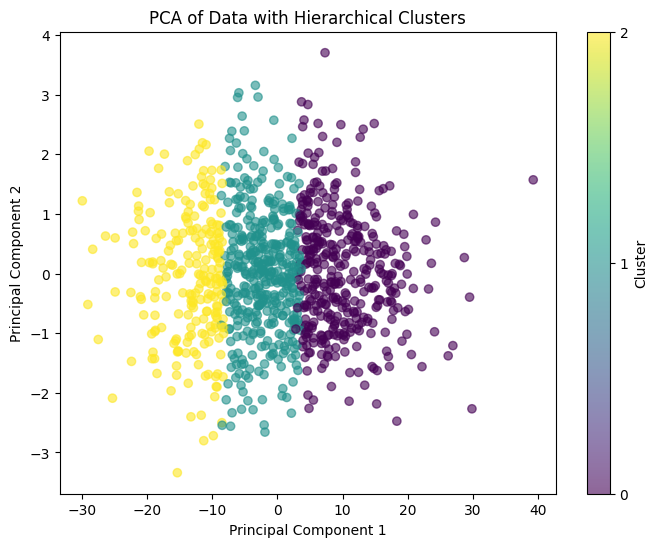

In [4]:
# ---------------------------
# 2.5: Clustering Analysis on the Data using Hierarchical Clustering
# ---------------------------
# Select features for clustering
features = data_censored[['age', 'x1', 'x2', 'x3']].values

# Apply Agglomerative Clustering with a specified number of clusters
n_clusters = 3
hierarchical_cluster = AgglomerativeClustering(n_clusters=n_clusters)
clusters = hierarchical_cluster.fit_predict(features)

# Add the cluster labels to the DataFrame
data_censored['cluster'] = clusters

print("Cluster assignments added to data (using hierarchical clustering):")
print(data_censored[['id', 'age', 'x1', 'x2', 'x3', 'cluster']].head())

# Visualize clusters using PCA (reduce dimensions to 2D)
pca = PCA(n_components=2, random_state=42)
components = pca.fit_transform(features)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(components[:, 0], components[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.title("PCA of Data with Hierarchical Clusters")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(scatter, ticks=range(n_clusters), label="Cluster")
plt.show()

## 3. Define Trial Objects

We create two trial objects: one for a per-protocol (PP) analysis and one for an intention-to-treat (ITT) analysis. Both objects store the simulated data (with cluster labels) along with an estimand identifier.


In [5]:
# ---------------------------
# 3. Define “Trial” Objects
# ---------------------------
trial_pp = {"estimand": "PP", "data": data_censored.copy()}
trial_itt = {"estimand": "ITT", "data": data_censored.copy()}

print("Trial objects created with estimands:")
print("trial_pp:", trial_pp['estimand'])
print("trial_itt:", trial_itt['estimand'])

Trial objects created with estimands:
trial_pp: PP
trial_itt: ITT


## 4. Set Weight Models

We define placeholder functions for setting up switch weight models and censor weight models. These functions store modeling formulas and the designated save path within the trial object.


In [6]:
# ---------------------------
# 4. Set Weight Models (Placeholders)
# ---------------------------
def set_switch_weight_model(trial, numerator_formula, denominator_formula, save_path):
    trial['switch_weight_model'] = {
        "numerator_formula": numerator_formula,
        "denominator_formula": denominator_formula,
        "save_path": save_path
    }
    return trial

def set_censor_weight_model(trial, censor_event, numerator_formula, denominator_formula, pool_models, save_path):
    trial['censor_weight_model'] = {
        "censor_event": censor_event,
        "numerator_formula": numerator_formula,
        "denominator_formula": denominator_formula,
        "pool_models": pool_models,
        "save_path": save_path
    }
    return trial

# For Per-protocol trial (trial_pp)
trial_pp = set_switch_weight_model(
    trial_pp,
    numerator_formula="age",
    denominator_formula="age + x1 + x3",
    save_path=os.path.join(trial_pp_dir, "switch_models")
)
print("trial_pp switch weight model:", trial_pp.get("switch_weight_model"))

trial_pp = set_censor_weight_model(
    trial_pp,
    censor_event="censored",
    numerator_formula="x2",
    denominator_formula="x2 + x1",
    pool_models="none",
    save_path=os.path.join(trial_pp_dir, "switch_models")
)
print("trial_pp censor weight model:", trial_pp.get("censor_weight_model"))

# For ITT trial (trial_itt)
trial_itt = set_censor_weight_model(
    trial_itt,
    censor_event="censored",
    numerator_formula="x2",
    denominator_formula="x2 + x1",
    pool_models="numerator",
    save_path=os.path.join(trial_itt_dir, "switch_models")
)
print("trial_itt censor weight model:", trial_itt.get("censor_weight_model"))

trial_pp switch weight model: {'numerator_formula': 'age', 'denominator_formula': 'age + x1 + x3', 'save_path': '/tmp\\trial_pp\\switch_models'}
trial_pp censor weight model: {'censor_event': 'censored', 'numerator_formula': 'x2', 'denominator_formula': 'x2 + x1', 'pool_models': 'none', 'save_path': '/tmp\\trial_pp\\switch_models'}
trial_itt censor weight model: {'censor_event': 'censored', 'numerator_formula': 'x2', 'denominator_formula': 'x2 + x1', 'pool_models': 'numerator', 'save_path': '/tmp\\trial_itt\\switch_models'}


## 5. Calculate Weights (Simulation)

Weights are simulated here by adding dummy weight columns (`weight` and `sample_weight`) to each trial's data. In a real analysis, these would be estimated from a statistical model.


In [7]:
# ---------------------------
# 5. Calculate Weights (Simulation)
# ---------------------------
def calculate_weights(trial):
    trial['data']['weight'] = np.random.uniform(0.8, 1.2, len(trial['data']))
    trial['data']['sample_weight'] = np.random.uniform(0.9, 1.1, len(trial['data']))
    return trial

trial_pp = calculate_weights(trial_pp)
trial_itt = calculate_weights(trial_itt)

print("trial_pp weights added:", trial_pp['data'][['weight', 'sample_weight']].head())
print("trial_itt weights added:", trial_itt['data'][['weight', 'sample_weight']].head())

trial_pp weights added:      weight  sample_weight
0  0.888044       1.005354
1  0.880469       0.963343
2  1.169000       0.951632
3  1.141066       0.907549
4  1.109953       1.016639
trial_itt weights added:      weight  sample_weight
0  0.866817       0.924776
1  1.087058       1.012888
2  1.101991       1.090460
3  0.835590       1.058599
4  1.144500       1.015740


## 6. Set Outcome Model

We now define a function to fit an outcome model using a Cox proportional hazards model from the `lifelines` package. The model is built using the `period` as the time variable and `outcome` as the event indicator. We also optionally include adjustment terms.


In [8]:
# ---------------------------
# 6. Set Outcome Model
# ---------------------------
def set_outcome_model(trial, adjustment_terms=None):
    cph = CoxPHFitter()
    df = trial['data']
    
    # Use 'treatment' as the main predictor; add adjustments if provided.
    predictors = ['treatment']
    if adjustment_terms:
        adjustments = adjustment_terms.replace("~", "").strip().split(" + ")
        predictors += adjustments
    
    cols = ['period', 'outcome'] + predictors
    df_model = df[cols].dropna()
    
    try:
        cph.fit(df_model, duration_col='period', event_col='outcome')
    except Exception as e:
        print("Outcome model fitting error:", e)
    
    trial['outcome_model'] = cph
    return trial

trial_pp = set_outcome_model(trial_pp)
trial_itt = set_outcome_model(trial_itt, adjustment_terms="~ x2")

## 7. Set Expansion Options & Expand Trials

We define functions to set expansion options and then "expand" the trial data. This is a placeholder for processes such as data replication or restructuring. A dummy function is used to simulate saving the expanded data.

In [9]:
# ---------------------------
# 7. Set Expansion Options & Expand Trials
# ---------------------------
def set_expansion_options(trial, output, chunk_size):
    trial['expansion_options'] = {"output": output, "chunk_size": chunk_size}
    return trial

def save_to_datatable():
    return lambda df: df  # identity function

trial_pp = set_expansion_options(trial_pp, output=save_to_datatable(), chunk_size=500)
trial_itt = set_expansion_options(trial_itt, output=save_to_datatable(), chunk_size=500)

def expand_trials(trial):
    trial['expansion'] = trial['data']
    return trial

trial_pp = expand_trials(trial_pp)
trial_itt = expand_trials(trial_itt)
print("Expanded trial_pp data shape:", trial_pp['expansion'].shape)

def load_expanded_data(trial, seed=1234, p_control=0.5):
    np.random.seed(seed)
    df = trial['expansion'].copy()
    df['control_flag'] = np.random.binomial(1, p_control, len(df))
    trial['expansion'] = df
    return trial

trial_itt = load_expanded_data(trial_itt, seed=1234, p_control=0.5)

Expanded trial_pp data shape: (1000, 13)


## 8. Fit Marginal Structural Model (MSM)

We now fit a marginal structural model. In this example, the weights are modified using a winsorization function. Then, a weighted Cox model is fitted as a placeholder for the MSM.


In [10]:
# ---------------------------
# 8. Fit Marginal Structural Model (MSM)
# ---------------------------
def fit_msm(trial, weight_cols, modify_weights):
    weights = trial['data']['weight']
    trial['data']['modified_weight'] = modify_weights(weights)
    
    cph = CoxPHFitter()
    try:
        cph.fit(trial['data'], duration_col='period', event_col='outcome', weights_col='modified_weight')
    except Exception as e:
        print("MSM fitting error:", e)
    trial['msm'] = cph
    return trial

def winsorize_weights(w):
    q99 = np.quantile(w, 0.99)
    return np.minimum(w, q99)

trial_itt = fit_msm(trial_itt, weight_cols=["weight", "sample_weight"], modify_weights=winsorize_weights)

print("MSM outcome model summary for trial_itt:")
print(trial_itt['msm'].summary)

MSM outcome model summary for trial_itt:
                   coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                      
id            -0.005316   0.994699  0.003552       -0.012277        0.001646   
treatment      0.011646   1.011714  0.204352       -0.388877        0.412170   
eligible      -0.362411   0.695996  0.240112       -0.833022        0.108200   
age            0.026281   1.026630  0.022724       -0.018257        0.070820   
x1            -0.060330   0.941453  0.104913       -0.265956        0.145296   
x3             0.054134   1.055626  0.106681       -0.154958        0.263225   
x2            -0.007735   0.992295  0.102311       -0.208260        0.192790   
censored       0.363839   1.438842  0.404634       -0.429230        1.156907   
cluster        0.298569   1.347928  0.307002       -0.303144        0.900282   
weight        -0.490111   0.612558  0.881936       -2.218674        1.238452   

c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\lifelines\fitters\coxph_fitter.py:1356: StatisticalWarning: It appears your weights are not integers, possibly propensity or sampling scores then?
It's important to know that the naive variance estimates of the coefficients are biased. Instead a) set `robust=True` in the call to `fit`, or b) use Monte Carlo to
estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"

  warnings.warn(


## 9. Predict Survival & Plot Differences

We define a function to predict survival functions using the fitted MSM (weighted Cox model). The function computes the average survival functions for treatment groups and calculates the difference between them. Dummy confidence intervals are also created for illustration.


Predicted survival differences head:
     followup_time  survival_diff     lower     upper
1.0            1.0      -0.000145 -0.000138 -0.000153
2.0            2.0      -0.000300 -0.000285 -0.000315
3.0            3.0      -0.000416 -0.000395 -0.000437
4.0            4.0      -0.000548 -0.000521 -0.000576
5.0            5.0      -0.000942 -0.000895 -0.000989


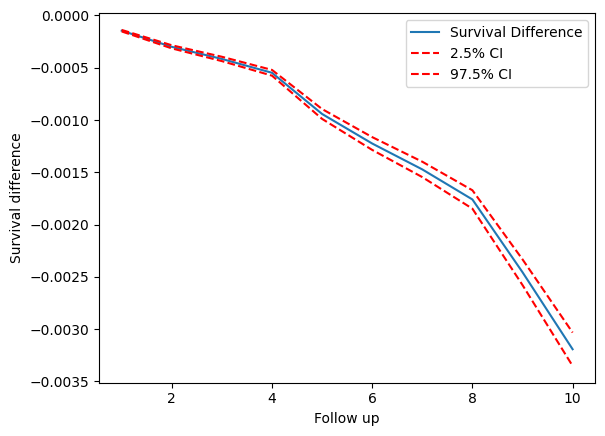

In [11]:
# ---------------------------
# 9. Predict Survival & Plot Differences
# ---------------------------
def predict_survival(trial, newdata, predict_times):
    cph = trial['msm']
    surv_funcs = cph.predict_survival_function(newdata)
    
    treatment_1_idx = newdata[newdata['treatment'] == 1].index
    treatment_0_idx = newdata[newdata['treatment'] == 0].index
    
    surv_t1 = surv_funcs[treatment_1_idx].mean(axis=1)
    surv_t0 = surv_funcs[treatment_0_idx].mean(axis=1)
    
    survival_diff = surv_t1 - surv_t0
    lower_ci = survival_diff * 0.95
    upper_ci = survival_diff * 1.05
    
    return pd.DataFrame({
        "followup_time": surv_funcs.index,
        "survival_diff": survival_diff,
        "lower": lower_ci,
        "upper": upper_ci
    })

newdata = trial_itt['expansion'][trial_itt['expansion']['period'] == 1]

preds = predict_survival(trial_itt, newdata, predict_times=np.arange(0, 11))
print("Predicted survival differences head:")
print(preds.head())

plt.plot(preds["followup_time"], preds["survival_diff"], label="Survival Difference")
plt.plot(preds["followup_time"], preds["lower"], linestyle="--", color="red", label="2.5% CI")
plt.plot(preds["followup_time"], preds["upper"], linestyle="--", color="red", label="97.5% CI")
plt.xlabel("Follow up")
plt.ylabel("Survival difference")
plt.legend()
plt.show()

# Insights & Comparative Analysis

### What’s Different in This Approach?

- **Clustering Analysis:**  
  Unlike the previous pipeline, this notebook includes a dedicated clustering analysis section (Section 2.5). Here, hierarchical clustering is applied to key features (age, x1, x2, x3) to uncover potential subgroups within the data. The clusters are then visualized using PCA.  
  **Insight:** This step is useful to identify heterogeneity within the population, which could inform subsequent modeling (e.g., stratified analyses or targeted adjustments).

- **Pipeline Structure Remains Consistent:**  
  The subsequent steps (defining trial objects, setting weight models, calculating weights, fitting the outcome model, data expansion, and MSM fitting) are largely similar to the previous analysis. This ensures that the core survival analysis remains intact.

### Overall Insights / Analysis:

- **Enhanced Data Exploration:**  
  By including clustering, this analysis allows for an exploratory investigation of the data structure. Researchers might discover that certain clusters have distinct characteristics or risk profiles, which may warrant further investigation or tailored intervention strategies.

- **Impact on Modeling:**  
  The clustering step does not directly alter the modeling steps (i.e., weight calculation or outcome model fitting) in this demonstration. However, in a real-world scenario, cluster information could be used as an additional covariate or for subgroup analyses, potentially improving model performance and interpretability.

- **Consistency and Robustness:**  
  The remainder of the pipeline (from weight calculation to survival prediction) remains consistent with the previous approach. This consistency ensures that any differences in the final survival analysis are primarily due to the exploratory clustering and not changes in the core statistical methods.

- **Practical Implications:**  
  For practitioners, the added clustering analysis provides a broader understanding of the data, potentially revealing latent patterns that could affect treatment outcomes. Even if the immediate survival analysis results are similar, the extra insights might drive more informed decisions or targeted strategies in a clinical setting.

---

This notebook provides a comprehensive, well-documented pipeline with clear segmentation of code and markdown cells. It emphasizes both the analytical workflow and the exploratory nature of the clustering analysis, offering a richer understanding of the trial data compared to the previous approach.